# Quantum Tunelling Implementation

This notebook will start with the simple case of two qubits. Note that this means we have $n=2$, so we have discretized the space into $2^2 = 4$ sections: $|00 \rangle, |01 \rangle, |10 \rangle, |11 \rangle$.  

In [19]:
import numpy as np
import numpy.linalg as la
import math as m
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.extensions import Initialize
#from qiskit_textbook.tools import random_state, array_to_latex # This import isn't working for me

import qiskit
print(qiskit.__qiskit_version__)

{'qiskit-terra': '0.14.1', 'qiskit-aer': '0.5.2', 'qiskit-ignis': '0.3.0', 'qiskit-ibmq-provider': '0.7.2', 'qiskit-aqua': '0.7.1', 'qiskit': '0.19.3'}


In [85]:
#I will start by defining functions for the quantum fourier transform (and inverse), potential, and D term



def QFT_2bit(qc):
    qc.h(1)
    qc.cu1(-m.pi/2, 1, 0)
    qc.h(0)
    return qc

def QFT_2bit_inv(qc):
    qc.h(0)
    qc.cu1(m.pi/2, 1, 0)
    qc.h(1)
    return qc

#This is the example from 
def inverse_qft(circuit):
    # First we create a QFT circuit of the correct size:
    qft_circ = QFT_2bit(QuantumCircuit(2))
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    #print(invqft_circ.draw())
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:2])
    return circuit.decompose() # .decompose() allows us 


def D(qc):
    qc.rz(-m.pi*m.pi/10, 0)
    qc.rz(-m.pi*m.pi/40, 1)
    qc.cu1(m.pi*m.pi/2, 1, 0)
    return qc


def P_step_pot(qc):
    qc.h(1)
    qc.u3(5., -m.pi/2, m.pi/2,1)
    qc.h(1)
    return qc

## It's a little unclear to me whether step potential is applied on 1 or 0. I think my convention
## is reversed from the paper, on arxiv, and we are told to put step on the highest order qubit, so it would be 1?



In [80]:
# Now we create the elements for the circuit
# This is the code that I created. I tried to follow exactly the paper
# https://www.nature.com/articles/srep02232.pdf and https://arxiv.org/pdf/1712.07326.pdf

qr = QuantumRegister(2) #the qubits needed
cr = ClassicalRegister(2) #for the measurement
qc = QuantumCircuit(qr, cr) #creating the quantum circuit

qc.x(1) 
qc.x(0)
qc.barrier()

QFT_2bit_inv(qc)
qc.barrier()

D(qc)

qc.barrier()
QFT_2bit(qc)

qc.barrier()

#P_step_pot(qc) #removing this for now for free particle


qc.barrier()
qc.measure( qr , cr )

qc.draw()

┌───┐ ░ ┌───┐             ░ ┌──────────────┐          ░              »
q35_0: ┤ X ├─░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■────────░───────■──────»
       ├───┤ ░ └───┘ │pi/2 ┌───┐ ░ ├──────────────┤ │4.9348  ░ ┌───┐ │-pi/2 »
q35_1: ┤ X ├─░───────■─────┤ H ├─░─┤ RZ(-0.24674) ├─■────────░─┤ H ├─■──────»
       └───┘ ░             └───┘ ░ └──────────────┘          ░ └───┘        »
c35_0: ═════════════════════════════════════════════════════════════════════»
                                                                            »
c35_1: ═════════════════════════════════════════════════════════════════════»
                                                                            »
«       ┌───┐ ░  ░ ┌─┐   
«q35_0: ┤ H ├─░──░─┤M├───
«       └───┘ ░  ░ └╥┘┌─┐
«q35_1: ──────░──░──╫─┤M├
«             ░  ░  ║ └╥┘
«c35_0: ════════════╩══╬═
«                      ║ 
«c35_1: ═══════════════╩═
«

11
01
10
00
[0.08105469 0.16503906 0.43066406 0.32324219]
[[0.00656986 0.01337719 0.03490734 0.02620029]
 [0.01337719 0.02723789 0.07107639 0.05334759]
 [0.03490734 0.07107639 0.18547153 0.13920879]
 [0.02620029 0.05334759 0.13920879 0.10448551]]


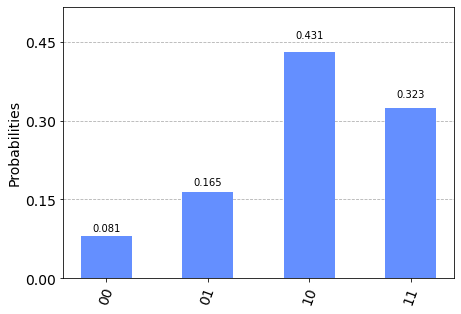

In [81]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts = execute(qc, backend, shots=1024).result().get_counts()


vector = np.zeros(len(counts))

ordering = {'00': 0, '01': 1, '10':2, '11':3}
for key in counts.keys():
    print(key) #printing the key to check the order
    vector[ordering[key]] = counts[key]
    
vector = vector / 1024
print(vector)

density_matrix = np.outer(vector, vector)
print(density_matrix)


plot_histogram(counts)

In [26]:
#initial state
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

qc.x(1)


qc.h(1)
qc.u3(5, -m.pi/2, m.pi/2, 1)
qc.h(1)

qc.h(0)
qc.cu1(m.pi/2, 1, 0)
qc.h(1)



qc.h(0)
qc.u3( -m.pi*m.pi/40, -m.pi/2, m.pi/2, 0)
qc.h(0)
qc.h(1)
qc.u3( -m.pi*m.pi/10, -m.pi/2, m.pi/2, 1)
qc.h(1)
qc.cu1(m.pi*m.pi/10,1,0)


qc.h(1)
qc.cu1(-m.pi/2, 1, 0)
qc.h(0)

qc.h(1)
qc.u3(5, -m.pi/2, m.pi/2, 1)
qc.h(1)

qc.barrier()





qc.h(1)
qc.u3(5, -m.pi/2, m.pi/2, 1)
qc.h(1)

qc.h(0)
qc.cu1(m.pi/2, 1, 0)
qc.h(1)



qc.h(0)
qc.u3( -m.pi*m.pi/40, -m.pi/2, m.pi/2, 0)
qc.h(0)
qc.h(1)
qc.u3( -m.pi*m.pi/10, -m.pi/2, m.pi/2, 1)
qc.h(1)
qc.cu1(m.pi*m.pi/10,1,0)


qc.h(1)
qc.cu1(-m.pi/2, 1, 0)
qc.h(0)

qc.h(1)
qc.u3(5, -m.pi/2, m.pi/2, 1)
qc.h(1)






qc.measure(q,c)

qc.draw()

┌───┐                                     ┌───┐»
q12_0: ┤ H ├───────────────────────────────■─────┤ H ├»
       ├───┤┌───┐┌──────────────────┐┌───┐ │pi/2 ├───┤»
q12_1: ┤ X ├┤ H ├┤ U3(5,-pi/2,pi/2) ├┤ H ├─■─────┤ H ├»
       └───┘└───┘└──────────────────┘└───┘       └───┘»
c12_0: ═══════════════════════════════════════════════»
                                                      »
c12_1: ═══════════════════════════════════════════════»
                                                      »
«       ┌─────────────────────────┐           ┌───┐                          »
«q12_0: ┤ U3(-0.24674,-pi/2,pi/2) ├───────────┤ H ├─────────────────■────────»
«       └──────────┬───┬──────────┘┌──────────┴───┴──────────┐┌───┐ │0.98696 »
«q12_1: ───────────┤ H ├───────────┤ U3(-0.98696,-pi/2,pi/2) ├┤ H ├─■────────»
«                  └───┘           └─────────────────────────┘└───┘          »
«c12_0: ═════════════════════════════════════════════════════════════════════»
«                                                                            »
«c12_1: ═════════════════════════════════════════════════════════════════════»
«                                                                            »
«                    ┌───┐                          ░ ┌───┐                    »
«q12_0: ──────■──────┤ H ├──────────────────────────░─┤ H ├────────────────────»
«       ┌───┐ │-pi/2 ├───┤┌──────────────────┐┌───┐ ░ ├───┤┌──────────────────┐»
«q12_1: ┤ H ├─■──────┤ H ├┤ U3(5,-pi/2,pi/2) ├┤ H ├─░─┤ H ├┤ U3(5,-pi/2,pi/2) ├»
«       └───┘        └───┘└──────────────────┘└───┘ ░ └───┘└──────────────────┘»
«c12_0: ═══════════════════════════════════════════════════════════════════════»
«                                                                              »
«c12_1: ═══════════════════════════════════════════════════════════════════════»
«                                                                              »
«                   ┌───┐┌─────────────────────────┐           ┌───┐           »
«q12_0: ──────■─────┤ H ├┤ U3(-0.24674,-pi/2,pi/2) ├───────────┤ H ├───────────»
«       ┌───┐ │pi/2 ├───┤└──────────┬───┬──────────┘┌──────────┴───┴──────────┐»
«q12_1: ┤ H ├─■─────┤ H ├───────────┤ H ├───────────┤ U3(-0.98696,-pi/2,pi/2) ├»
«       └───┘       └───┘           └───┘           └─────────────────────────┘»
«c12_0: ═══════════════════════════════════════════════════════════════════════»
«                                                                              »
«c12_1: ═══════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                   ┌───┐                    ┌─┐        
«q12_0: ──────■──────────────■──────┤ H ├────────────────────┤M├────────
«       ┌───┐ │0.98696 ┌───┐ │-pi/2 ├───┤┌──────────────────┐└╥┘┌───┐┌─┐
«q12_1: ┤ H ├─■────────┤ H ├─■──────┤ H ├┤ U3(5,-pi/2,pi/2) ├─╫─┤ H ├┤M├
«       └───┘          └───┘        └───┘└──────────────────┘ ║ └───┘└╥┘
«c12_0: ══════════════════════════════════════════════════════╩═══════╬═
«                                                                     ║ 
«c12_1: ══════════════════════════════════════════════════════════════╩═
«

01
00
10
11
[0.01367188 0.01464844 0.88183594 0.08984375]
[[1.86920166e-04 2.00271606e-04 1.20563507e-02 1.22833252e-03]
 [2.00271606e-04 2.14576721e-04 1.29175186e-02 1.31607056e-03]
 [1.20563507e-02 1.29175186e-02 7.77634621e-01 7.92274475e-02]
 [1.22833252e-03 1.31607056e-03 7.92274475e-02 8.07189941e-03]]


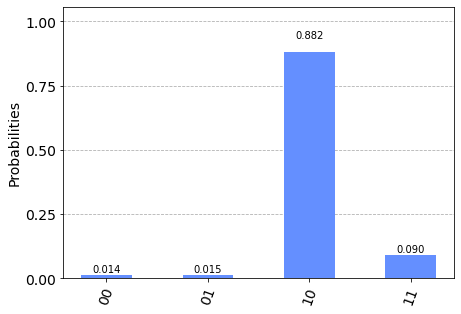

In [27]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts = execute(qc, backend, shots=1024).result().get_counts()


vector = np.zeros(len(counts))

ordering = {'00': 0, '01': 1, '10':2, '11':3}
for key in counts.keys():
    print(key) #printing the key to check the order
    vector[ordering[key]] = counts[key]
    
vector = vector / 1024
print(vector)

density_matrix = np.outer(vector, vector)
print(density_matrix)


plot_histogram(counts)

## References

https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

https://arxiv.org/pdf/1712.07326.pdf


## Trying more versions

In [103]:
#https://www.nature.com/articles/srep00597.pdf
#this one seems the same as my code

"""
1- Prepare a state in |01>
2- place peaks at |00> and |10> and a trough at |01> and |11>
    --They said for free particle we should remove the potential and expect a more uniform distribution

"""
qr = QuantumRegister(2) #the qubits needed
cr = ClassicalRegister(2) #for the measurement
qc = QuantumCircuit(qr, cr) #creating the quantum circuit

qc.x(0) #preparing the state in |01>
qc.barrier()

qc.h(0)
qc.cu1(m.pi/2, 0, 1)
qc.h(1)
qc.barrier()

qc.rz(-m.pi*m.pi/10, 0)
qc.rz(-m.pi*m.pi/40, 1)
qc.cu1(m.pi*m.pi/2, 0, 1)

qc.barrier()
qc.h(1)
qc.cu1(-m.pi/2, 1, 0)
qc.h(0)

qc.barrier()
#potential for double well
# "apply on lowest order"
#qc.h(0)
#qc.u3(5, -m.pi/2, m.pi/2, 0)
#qc.h(0)
#neither 0 nor 1 is returning the graph we expect?
## ^i'm commenting this out to try the free particle

##### trying 2 time steps?
qc.barrier()
qc.h(0)
qc.cu1(m.pi/2, 0, 1)
qc.h(1)
qc.barrier()

qc.rz(-m.pi*m.pi/10, 0)
qc.rz(-m.pi*m.pi/40, 1)
qc.cu1(m.pi*m.pi/2, 0, 1)

qc.barrier()
qc.h(1)
qc.cu1(-m.pi/2, 1, 0)
qc.h(0)

qc.barrier()
#potential for double well
# "apply on lowest order"
#qc.h(0)
#qc.u3(5, -m.pi/2, m.pi/2, 0)
#qc.h(0)
#neither 0 nor 1 is returning the graph we expect?
## ^i'm commenting this out to try the free particle


qc.barrier()
qc.measure( qr , cr )

qc.draw()


┌───┐ ░ ┌───┐             ░ ┌──────────────┐          ░              »
q49_0: ┤ X ├─░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■────────░───────■──────»
       └───┘ ░ └───┘ │pi/2 ┌───┐ ░ ├──────────────┤ │4.9348  ░ ┌───┐ │-pi/2 »
q49_1: ──────░───────■─────┤ H ├─░─┤ RZ(-0.24674) ├─■────────░─┤ H ├─■──────»
             ░             └───┘ ░ └──────────────┘          ░ └───┘        »
c49_0: ═════════════════════════════════════════════════════════════════════»
                                                                            »
c49_1: ═════════════════════════════════════════════════════════════════════»
                                                                            »
«       ┌───┐ ░  ░ ┌───┐             ░ ┌──────────────┐          ░      »
«q49_0: ┤ H ├─░──░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■────────░──────»
«       └───┘ ░  ░ └───┘ │pi/2 ┌───┐ ░ ├──────────────┤ │4.9348  ░ ┌───┐»
«q49_1: ──────░──░───────■─────┤ H ├─░─┤ RZ(-0.24674) ├─■────────░─┤ H ├»
«             ░  ░             └───┘ ░ └──────────────┘          ░ └───┘»
«c49_0: ════════════════════════════════════════════════════════════════»
«                                                                       »
«c49_1: ════════════════════════════════════════════════════════════════»
«                                                                       »
«               ┌───┐ ░  ░ ┌─┐   
«q49_0: ─■──────┤ H ├─░──░─┤M├───
«        │-pi/2 └───┘ ░  ░ └╥┘┌─┐
«q49_1: ─■────────────░──░──╫─┤M├
«                     ░  ░  ║ └╥┘
«c49_0: ════════════════════╩══╬═
«                              ║ 
«c49_1: ═══════════════════════╩═
«

11
01
10
00
[0.20019531 0.24707031 0.22851562 0.32421875]
[[0.04007816 0.04946232 0.04574776 0.06490707]
 [0.04946232 0.06104374 0.05645943 0.08010483]
 [0.04574776 0.05645943 0.05221939 0.07408905]
 [0.06490707 0.08010483 0.07408905 0.1051178 ]]


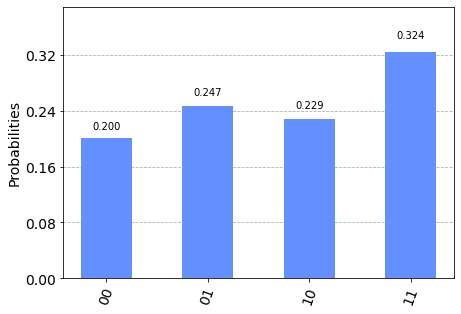

In [104]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts = execute(qc, backend, shots=1024).result().get_counts()


vector = np.zeros(len(counts))

ordering = {'00': 0, '01': 1, '10':2, '11':3}
for key in counts.keys():
    print(key) #printing the key to check the order
    vector[ordering[key]] = counts[key]
    
vector = vector / 1024
print(vector)

density_matrix = np.outer(vector, vector)
print(density_matrix)


plot_histogram(counts)

## TRying https://arxiv.org/pdf/1202.1536.pdf



In [17]:
# free particle

dt = 0.1

qr = QuantumRegister(2) #the qubits needed
cr = ClassicalRegister(2) #for the measurement
qc = QuantumCircuit(qr, cr) #creating the quantum circuit

qc.x(0) #preparing the state in |01>
qc.barrier()

qc.h(1)
qc.cu1(m.pi/2, 0, 1)
qc.h(0)
qc.barrier()

qc.rz(-m.pi*m.pi * dt/8, 0)
qc.rz(-m.pi*m.pi * dt, 1)
qc.cu1(m.pi*m.pi*dt*2/2, 0, 1) #am i off by a factor of 2?

qc.barrier()
qc.h(0)
qc.cu1(-m.pi/2, 1, 0)
qc.h(1)


qc.barrier()

### 2nd time step?
qc.barrier()

qc.h(1)
qc.cu1(m.pi/2, 0, 1)
qc.h(0)
qc.barrier()

qc.rz(-m.pi*m.pi * dt/8, 0)
qc.rz(-m.pi*m.pi * dt, 1)
qc.cu1(m.pi*m.pi*dt*2/2, 0, 1) #am i off by a factor of 2?

qc.barrier()
qc.h(0)
qc.cu1(-m.pi/2, 1, 0)
qc.h(1)


###

### 3rd time step?
qc.barrier()

qc.h(1)
qc.cu1(m.pi/2, 0, 1)
qc.h(0)
qc.barrier()

qc.rz(-m.pi*m.pi * dt/8, 0)
qc.rz(-m.pi*m.pi * dt, 1)
qc.cu1(m.pi*m.pi*dt*2/2, 0, 1) #am i off by a factor of 2?

qc.barrier()
qc.h(0)
qc.cu1(-m.pi/2, 1, 0)
qc.h(1)


###

qc.barrier()

qc.h(1)
qc.cu1(m.pi/2, 0, 1)
qc.h(0)
qc.barrier()

qc.rz(-m.pi*m.pi * dt/8, 0)
qc.rz(-m.pi*m.pi * dt, 1)
qc.cu1(m.pi*m.pi*dt*2/2, 0, 1) #am i off by a factor of 2?

qc.barrier()
qc.h(0)
qc.cu1(-m.pi/2, 1, 0)
qc.h(1)


###

qc.barrier()

qc.h(1)
qc.cu1(m.pi/2, 0, 1)
qc.h(0)
qc.barrier()

qc.rz(-m.pi*m.pi * dt/8, 0)
qc.rz(-m.pi*m.pi * dt, 1)
qc.cu1(m.pi*m.pi*dt*2/2, 0, 1) #am i off by a factor of 2?

qc.barrier()
qc.h(0)
qc.cu1(-m.pi/2, 1, 0)
qc.h(1)


###
qc.barrier()
qc.measure( qr , cr )

qc.draw()


┌───┐ ░             ┌───┐ ░ ┌──────────────┐           ░ ┌───┐        »
q8_0: ┤ X ├─░───────■─────┤ H ├─░─┤ RZ(-0.12337) ├─■─────────░─┤ H ├─■──────»
      └───┘ ░ ┌───┐ │pi/2 └───┘ ░ ├──────────────┤ │0.98696  ░ └───┘ │-pi/2 »
q8_1: ──────░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■─────────░───────■──────»
            ░ └───┘             ░ └──────────────┘           ░              »
c8_0: ══════════════════════════════════════════════════════════════════════»
                                                                            »
c8_1: ══════════════════════════════════════════════════════════════════════»
                                                                            »
«            ░  ░             ┌───┐ ░ ┌──────────────┐           ░ ┌───┐»
«q8_0: ──────░──░───────■─────┤ H ├─░─┤ RZ(-0.12337) ├─■─────────░─┤ H ├»
«      ┌───┐ ░  ░ ┌───┐ │pi/2 └───┘ ░ ├──────────────┤ │0.98696  ░ └───┘»
«q8_1: ┤ H ├─░──░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■─────────░──────»
«      └───┘ ░  ░ └───┘             ░ └──────────────┘           ░      »
«c8_0: ═════════════════════════════════════════════════════════════════»
«                                                                       »
«c8_1: ═════════════════════════════════════════════════════════════════»
«                                                                       »
«                    ░             ┌───┐ ░ ┌──────────────┐           ░ ┌───┐»
«q8_0: ─■────────────░───────■─────┤ H ├─░─┤ RZ(-0.12337) ├─■─────────░─┤ H ├»
«       │-pi/2 ┌───┐ ░ ┌───┐ │pi/2 └───┘ ░ ├──────────────┤ │0.98696  ░ └───┘»
«q8_1: ─■──────┤ H ├─░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■─────────░──────»
«              └───┘ ░ └───┘             ░ └──────────────┘           ░      »
«c8_0: ══════════════════════════════════════════════════════════════════════»
«                                                                            »
«c8_1: ══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                    ░             ┌───┐ ░ ┌──────────────┐           ░ ┌───┐»
«q8_0: ─■────────────░───────■─────┤ H ├─░─┤ RZ(-0.12337) ├─■─────────░─┤ H ├»
«       │-pi/2 ┌───┐ ░ ┌───┐ │pi/2 └───┘ ░ ├──────────────┤ │0.98696  ░ └───┘»
«q8_1: ─■──────┤ H ├─░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■─────────░──────»
«              └───┘ ░ └───┘             ░ └──────────────┘           ░      »
«c8_0: ══════════════════════════════════════════════════════════════════════»
«                                                                            »
«c8_1: ══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                    ░             ┌───┐ ░ ┌──────────────┐           ░ ┌───┐»
«q8_0: ─■────────────░───────■─────┤ H ├─░─┤ RZ(-0.12337) ├─■─────────░─┤ H ├»
«       │-pi/2 ┌───┐ ░ ┌───┐ │pi/2 └───┘ ░ ├──────────────┤ │0.98696  ░ └───┘»
«q8_1: ─■──────┤ H ├─░─┤ H ├─■───────────░─┤ RZ(-0.98696) ├─■─────────░──────»
«              └───┘ ░ └───┘             ░ └──────────────┘           ░      »
«c8_0: ══════════════════════════════════════════════════════════════════════»
«                                                                            »
«c8_1: ══════════════════════════════════════════════════════════════════════»
«                                                                            »
«                    ░ ┌─┐   
«q8_0: ─■────────────░─┤M├───
«       │-pi/2 ┌───┐ ░ └╥┘┌─┐
«q8_1: ─■──────┤ H ├─░──╫─┤M├
«              └───┘ ░  ║ └╥┘
«c8_0: ═════════════════╩══╬═
«                          ║ 
«c8_1: ════════════════════╩═
«

01
00
10
11
[0.1171875  0.50683594 0.27734375 0.09863281]
[[0.01373291 0.05939484 0.03250122 0.01155853]
 [0.05939484 0.25688267 0.14056778 0.04999065]
 [0.03250122 0.14056778 0.07691956 0.02735519]
 [0.01155853 0.04999065 0.02735519 0.00972843]]


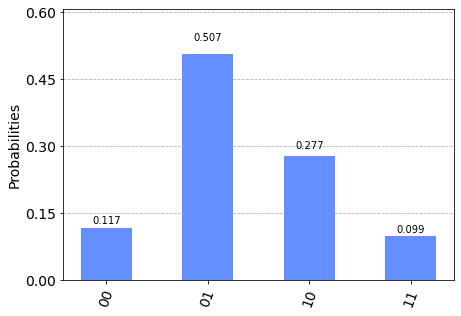

In [18]:

backend = BasicAer.get_backend('qasm_simulator') #'statevector_simulator' doesn't seem to return the right result
counts = execute(qc, backend, shots=1024).result().get_counts()


vector = np.zeros(len(counts))

ordering = {'00': 0, '01': 1, '10':2, '11':3}
for key in counts.keys():
    print(key) #printing the key to check the order
    vector[ordering[key]] = counts[key]
    
vector = vector / 1024
print(vector)

density_matrix = np.outer(vector, vector)
print(density_matrix)

#top qubit is 0. the results seem weird for larger time steps/


plot_histogram(counts)